### 1. 神经网络的底层搭建
原生代码实现可参照：[https://blog.csdn.net/u013733326/article/details/80086090](https://blog.csdn.net/u013733326/article/details/80086090)

下面用TensorFlow实现手势识别：

-----

### 2 神经网络的应用
-----

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.python.framework import ops

import cnn_utils

%matplotlib inline
np.random.seed(1)

y = 1


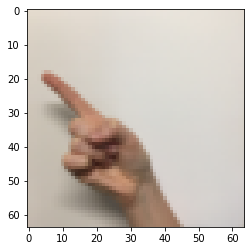

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = cnn_utils.load_dataset()

index = 7
plt.imshow(X_train_orig[index])
print("y = {}".format(np.squeeze(Y_train_orig[:, index])))

In [3]:
X_train, X_test = X_train_orig / 255., X_test_orig / 255.
Y_train, Y_test = cnn_utils.convert_to_one_hot(Y_train_orig, len(classes)).T, cnn_utils.convert_to_one_hot(Y_test_orig, len(classes)).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [4]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    为session创建占位符

    :param n_H0: 实数，输入图像的高度
    :param n_W0: 实数，输入图像的宽度
    :param n_C0: 实数，输入的通道数
    :param n_y: 实数，分类数
    :return:
        X - 输入数据的占位符，维度为[None, n_H0, n_W0, n_C0]，类型为"float"
        Y - 输入数据的标签的占位符，维度为[None, n_y]，维度为"float"
    """
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    return X, Y

In [5]:
# 测试一下
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


In [6]:
def initialize_parameters():
    """
    初始化权值矩阵，这里我们把权值矩阵硬编码
    W1 : [4, 4, 3, 8]
    W2 : [2, 2, 8, 16]

    :return:
        包含了tensor类型的W1、W2的字典
    """
    tf.set_random_seed(1)

    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer=tf.initializers.glorot_uniform(seed=0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer=tf.initializers.glorot_uniform(seed=0))

    parameters = {"W1": W1,
                  "W2": W2}

    return parameters

In [7]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

    sess_test.close()

W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


In [8]:
def forward_propagation(X, parameters):
    """
    实现前向传播
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    :param X: 输入数据的placeholder，维度为(输入节点数量，样本数量)
    :param parameters: 包含了“W1”和“W2”的python字典。
    :return:
        Z3 - 最后一个LINEAR节点的输出
    """
    W1 = parameters['W1']
    W2 = parameters['W2']

    # Conv2d : 步伐：1，填充方式：“SAME”
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
    # ReLU:
    A1 = tf.nn.relu(Z1)
    # Max pool: 窗口大小：8x8，步伐：8x8，填充方式：“SAME”
    P1 = tf.nn.max_pool(A1, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1], padding='SAME')

    # Conv2d : 步伐：1，填充方式：“SAME”
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    # ReLU:
    A2 = tf.nn.relu(Z2)
    # Max pool : 过滤器大小：4x4，步伐：4x4，填充方式：“SAME”
    P2 = tf.nn.max_pool(A2, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding="SAME")

    # 一维化上一层的输出
    P = tf.layers.flatten(P2)

    # 全连接层（FC）：使用没有非线性激活函数的全连接层
    Z3 = tf.layers.dense(P, 6, activation=None)
    return Z3

In [9]:
# 测试一下：

tf.reset_default_graph()
np.random.seed(1)

with tf.Session() as sess_test:
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)

    init = tf.global_variables_initializer()
    sess_test.run(init)

    a = sess_test.run(Z3, feed_dict={X: np.random.randn(2, 64, 64, 3),
                                     Y: np.random.randn(2, 6)})
    print("Z3 = {}".format(a))
    sess_test.close()

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.
Z3 = [[ 1.4416982  -0.24909675  5.4504995  -0.26189643 -0.2066989   1.3654672 ]
 [ 1.4070848  -0.02573231  5.0892797  -0.48669893 -0.40940714  1.2624854 ]]


In [10]:
def compute_cost(Z3, Y):
    """
    计算成本
    参数：
        Z3 - 正向传播最后一个LINEAR节点的输出，维度为（6，样本数）。
        Y - 标签向量的placeholder，和Z3的维度相同

    返回：
        cost - 计算后的成本

    """

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z3,
                                                                  labels=Y))

    return cost

In [11]:
# 测试一下
tf.reset_default_graph()

with tf.Session() as sess_test:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)

    init = tf.global_variables_initializer()
    sess_test.run(init)
    a = sess_test.run(cost, feed_dict={X: np.random.randn(4, 64, 64, 3),
                                       Y: np.random.randn(4, 6)})
    print("cost = {}".format(a))

    sess_test.close()

cost = 4.664870262145996


In [12]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009,
          num_epochs=100, minibatch_size=64, print_cost=True, isPlot=True):
    """
    使用TensorFlow实现三层的卷积神经网络
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    :param X_train: 训练数据，维度为(None, 64, 64, 3)
    :param Y_train: 训练数据对应的标签，维度为(None, n_y = 6)
    :param X_test: 测试数据，维度为(None, 64, 64, 3)
    :param Y_test: 测试数据对应的标签，维度为(None, n_y = 6)
    :param learning_rate: 学习率
    :param num_epochs: 遍历整个数据集的次数
    :param minibatch_size: 每个小批量数据块的大小
    :param print_cost: 是否打印成本值，每遍历100次整个数据集打印一次
    :param isPlot: 是否绘制图谱
    :return:
        train_accuracy - 实数，训练集的准确度
        test_accuracy - 实数，测试集的准确度
        parameters - 学习后的参数
    """
    ops.reset_default_graph()  # 能够重新运行模型而不覆盖tf变量
    tf.set_random_seed(1)  # 确保你的数据和我一样
    seed = 3  # 指定numpy的随机种子
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []

    # 为当前维度创建占位符
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # 初始化参数
    parameters = initialize_parameters()

    # 前向传播
    Z3 = forward_propagation(X, parameters)

    # 计算成本
    cost = compute_cost(Z3, Y)

    # 反向传播 由于框架已经实现了反向传播，我们只需要选择一个优化器就行了
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # 全局初始化所有变量
    init = tf.global_variables_initializer()

    # 开始运行
    with tf.Session() as sess:
        # 初始化参数
        sess.run(init)

        # 开始遍历数据集
        for epoch in range(num_epochs):
            minibatch_cost = 0
            num_minibatches = int(m / minibatch_size)  # 获取数据块的数量
            seed = seed + 1
            minibatches = cnn_utils.random_mini_batches(X_train, Y_train, minibatch_size, seed)

            # 对每个数据块进行处理
            for minibatch in minibatches:
                # 选择一个数据块
                (minibatch_x, minibatch_y) = minibatch
                # 最小化这个数据块的成本
                _, temp_cost = sess.run([optimizer, cost],
                                        feed_dict={
                                            X: minibatch_x,
                                            Y: minibatch_y
                                        })
                # 累加数据块的成本值
                minibatch_cost += temp_cost / num_minibatches

            # 是否打印成本
            if print_cost:
                # 每5代打印一次
                if epoch % 5 == 0:
                    print("当前是第 {} 代，成本值为：{}".format(epoch, minibatch_cost))

            # 记录成本
            if epoch % 1 == 0:
                costs.append(minibatch_cost)

        # 数据处理完毕，绘制成本曲线
        if isPlot:
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate = {}".format(learning_rate))
            plt.show()

        # 开始预测数据
        ## 计算当前的预测情况
        predict_op = tf.arg_max(Z3, 1)
        corrent_prediction = tf.equal(predict_op, tf.arg_max(Y, 1))

        ## 计算准确度
        accuracy = tf.reduce_mean(tf.cast(corrent_prediction, 'float'))
        print("corrent_prediction accuracy= {}".format(accuracy))

        train_accuracy = accuracy.eval({X: X_train,
                                        Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test,
                                        Y: Y_test})

        print("训练集准确度：{}".format(train_accuracy))
        print("测试集准确度：{}".format(test_accuracy))

        return train_accuracy, test_accuracy, parameters

当前是第 0 代，成本值为：1.9213323593139648
当前是第 5 代，成本值为：1.9041557535529137
当前是第 10 代，成本值为：1.9043088406324387
当前是第 15 代，成本值为：1.9044771641492844
当前是第 20 代，成本值为：1.9018756002187729
当前是第 25 代，成本值为：1.7840775027871132
当前是第 30 代，成本值为：1.6810519248247147
当前是第 35 代，成本值为：1.618206724524498
当前是第 40 代，成本值为：1.5979715660214424
当前是第 45 代，成本值为：1.5667067170143127
当前是第 50 代，成本值为：1.554486371576786
当前是第 55 代，成本值为：1.5021868869662285
当前是第 60 代，成本值为：1.461034670472145
当前是第 65 代，成本值为：1.304477334022522
当前是第 70 代，成本值为：1.201501227915287
当前是第 75 代，成本值为：1.1442293748259544
当前是第 80 代，成本值为：1.0983676128089428
当前是第 85 代，成本值为：1.07741105183959
当前是第 90 代，成本值为：1.0431732051074505
当前是第 95 代，成本值为：1.0235813297331333
当前是第 100 代，成本值为：1.0107476897537708
当前是第 105 代，成本值为：0.958832249045372
当前是第 110 代，成本值为：0.9587796293199062
当前是第 115 代，成本值为：0.9571278169751167
当前是第 120 代，成本值为：0.9306484311819077
当前是第 125 代，成本值为：0.8950737975537777
当前是第 130 代，成本值为：0.9239861853420734
当前是第 135 代，成本值为：0.8635294400155544
当前是第 140 代，成本值为：0.8666736781597137
当前是第 145 代，成本值为

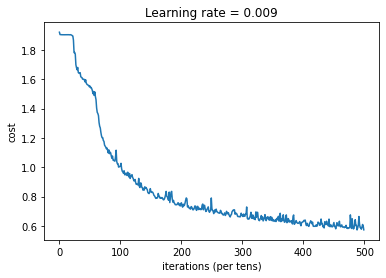

In [13]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test, num_epochs=500)